In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from pandas.plotting import parallel_coordinates

# set plt style
pd.set_option('display.max_columns', 500)

In [173]:
df = pd.read_csv('Groceries_dataset.csv')
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [174]:
# Create TransactionID which is a combination of Member_number and Date
df['Member_number'] = df['Member_number'].astype(str)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['TransactionID'] = df['Member_number'].astype(str) + '-' + df['Date']

In [175]:
print(f"The dataset covers {df['Date'].min()} to {df['Date'].max()}")
print(f"There are unique {df['Member_number'].nunique()} customers in the dataset")
print(f"There are unique {df['itemDescription'].nunique()} items in the dataset")
print(f"There are unique {df['TransactionID'].nunique()} transactions in the dataset")

The dataset covers 2014-01-01 to 2015-12-30
There are unique 3898 customers in the dataset
There are unique 167 items in the dataset
There are unique 14963 transactions in the dataset


### Exploratory Analysis

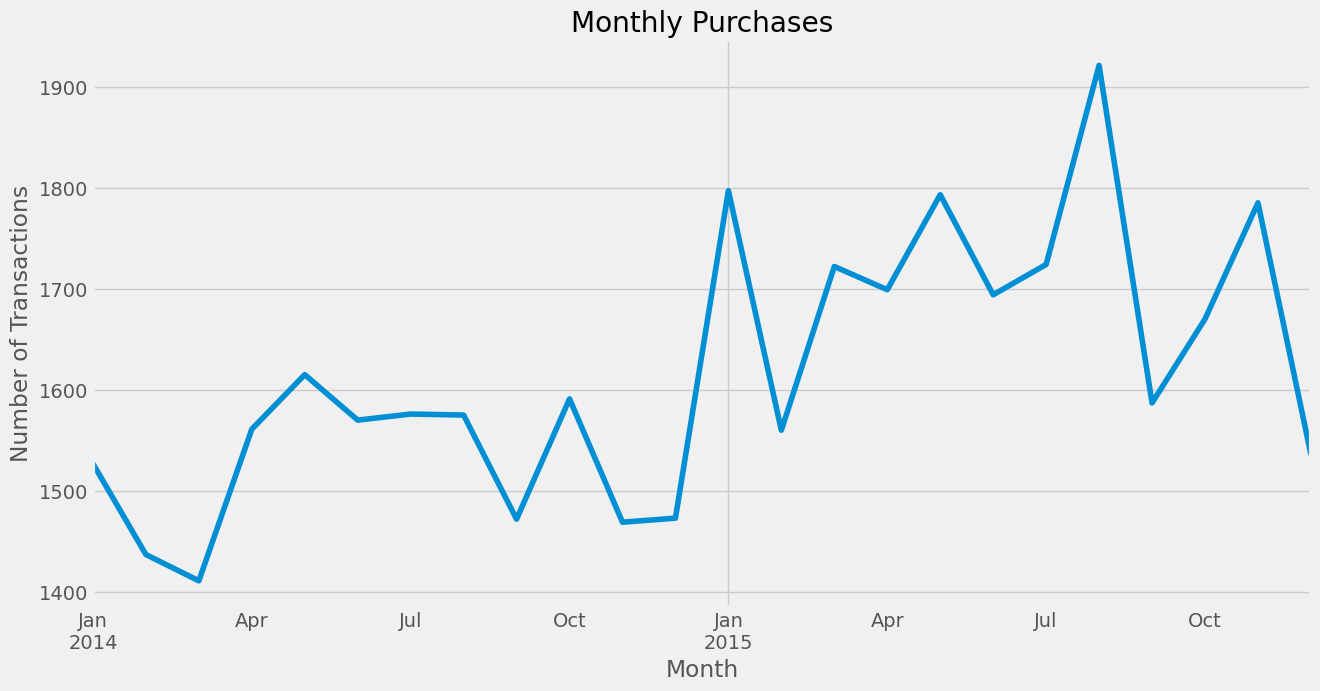

In [176]:
# Monthly sales

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Extract the month and year
df['YearMonth'] = df['Date'].dt.to_period('M')

# Aggregate transactions by month
monthly_purchases = df.groupby('YearMonth').size()

# Plotting
plt.figure(figsize=(14,7))
monthly_purchases.plot(kind='line')
plt.title('Monthly Purchases')
plt.ylabel('Number of Transactions')
plt.xlabel('Month')
plt.grid(True)
plt.show()

We see a big jump in sales at the begining of January 2015. Lets explore what drove those sales.

In [180]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Extract the month and year
df['YearMonth'] = df['Date'].dt.to_period('M')

# Create a dataframe that aggregates the count of each item on a monthly basis
item_monthly_sales = df.groupby(['YearMonth', 'itemDescription']).size().unstack().fillna(0)

# Define the start and end months for the period of interest
start_month = pd.Period('2014-12')
end_month = pd.Period('2015-01')

# Calculate the difference in sales for each item between start and end months
growth_data = item_monthly_sales.loc[end_month] - item_monthly_sales.loc[start_month]

# Sort the items based on this difference
sorted_growth = growth_data.sort_values(ascending=False)

print('Top 10 Growing Items from Dec 2014 to Jan 2015')
# show the top 10 items
sorted_growth.head(10)



Top 10 Growing Items from Dec 2014 to Jan 2015


itemDescription
sausage           50.0
tropical fruit    39.0
frankfurter       37.0
whole milk        36.0
citrus fruit      26.0
chicken           25.0
pork              22.0
yogurt            21.0
canned beer       21.0
pip fruit         21.0
dtype: float64

In [ ]:
# Top 10 items sold
top_items = df['itemDescription'].value_counts().nlargest(15)
print("Top 10 items sold:")
print(top_items)

Top 10 items sold:
whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
pastry               785
pip fruit            744
shopping bags        731
canned beer          717
bottled beer         687
Name: itemDescription, dtype: int64


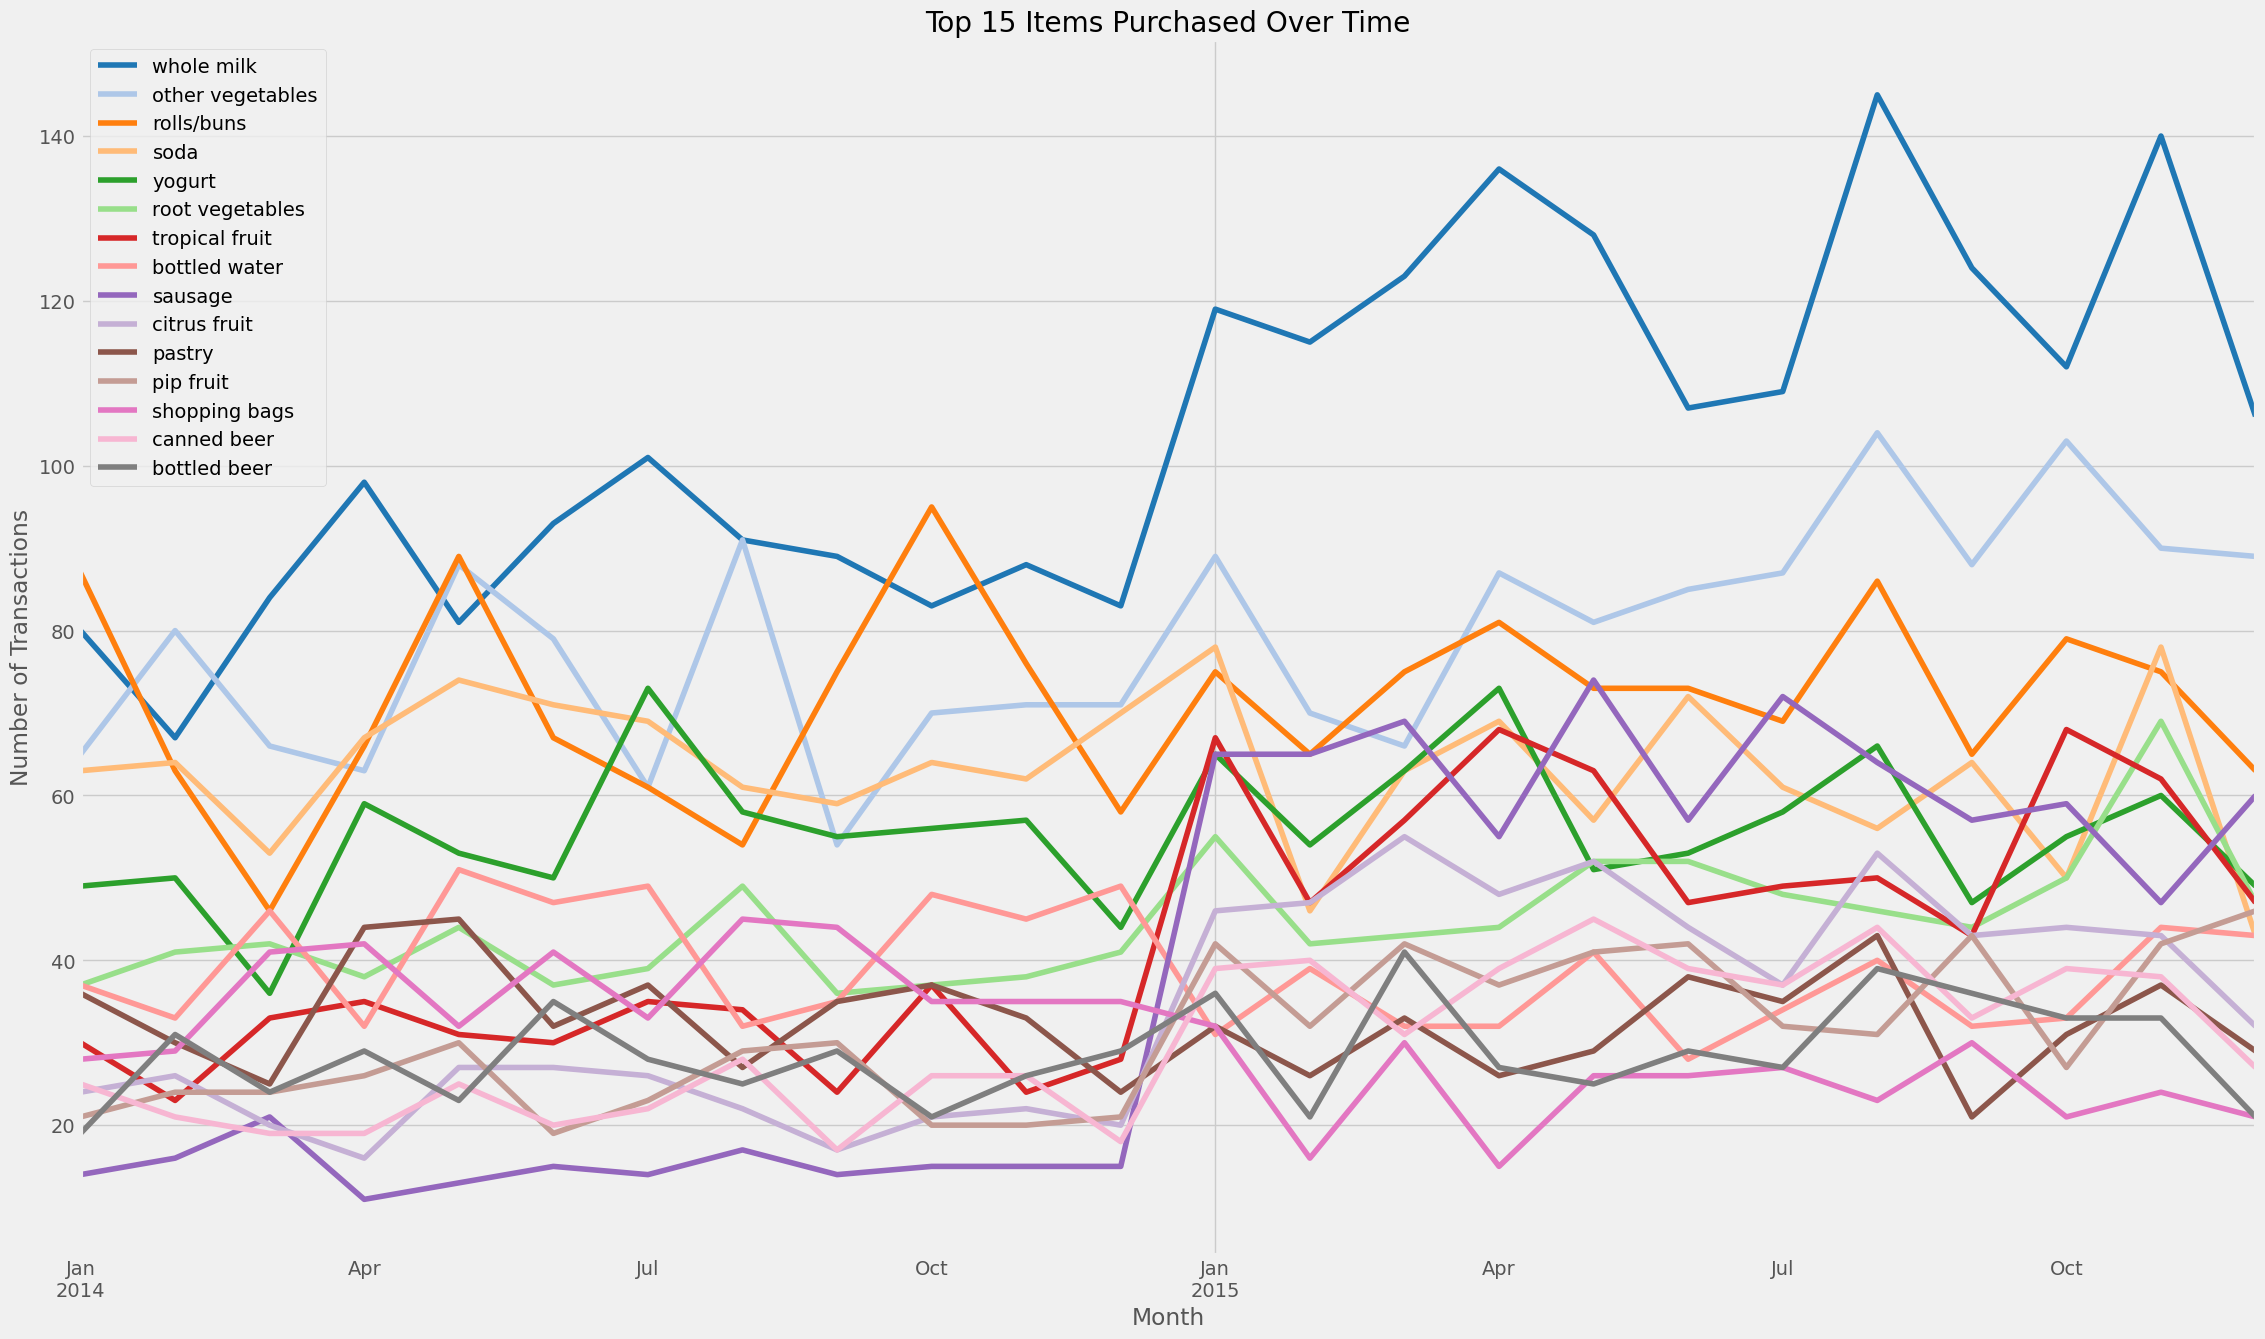

In [ ]:
# Filter the dataframe to only include the top 15 items
top_items_over_time = df[df['itemDescription'].isin(top_items.index)]

# Get the colors from the tab20 colormap
colors = plt.cm.tab20.colors

# Plotting
plt.figure(figsize=(25,15))
for idx, item in enumerate(top_items.index):
    monthly_data = top_items_over_time[top_items_over_time['itemDescription'] == item].groupby('YearMonth').size()
    monthly_data.plot(label=item, color=colors[idx])

plt.legend()
plt.title('Top 15 Items Purchased Over Time')
plt.ylabel('Number of Transactions')
plt.xlabel('Month')
plt.grid(True)
plt.show()


In [ ]:
frequent_shoppers = df.groupby('Member_number').size().nlargest(10)
# format and print 
frequent_shoppers = pd.DataFrame(frequent_shoppers).reset_index()
frequent_shoppers.columns = ['Member_number', 'Number of Transactions']
frequent_shoppers

,Member_number,Number of Transactions
0,3180,36
1,2051,33
2,3050,33
3,3737,33
4,2271,31
5,2433,31
6,2625,31
7,3915,31
8,3872,30
9,2394,29


In [ ]:
# use transactionid to show average # of items per transaction
avg_items_per_transaction = df.groupby('TransactionID')['itemDescription'].size().mean()
print(f"The average number of items per transaction is {round(avg_items_per_transaction, 2)}")

The average number of items per transaction is 2.59


### Apriori 

The Apriori algorithm is commonly used for market basket analysis to find frequent itemsets and association rules in transactional data. The algorithm works by identifying the most frequent individual items in the dataset and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the dataset.

In [ ]:
df.head()

,Member_number,Date,itemDescription,TransactionID,YearMonth
0,1808,2015-07-21,tropical fruit,1808-2015-07-21,2015-07
1,2552,2015-01-05,whole milk,2552-2015-01-05,2015-01
2,2300,2015-09-19,pip fruit,2300-2015-09-19,2015-09
3,1187,2015-12-12,other vegetables,1187-2015-12-12,2015-12
4,3037,2015-02-01,whole milk,3037-2015-02-01,2015-02


In [ ]:
# Group by TransactionID and create a list of items
transactions = df.groupby('TransactionID')['itemDescription'].apply(list).reset_index(name='Items')

# Use TransactionEncoder
te = TransactionEncoder()
te_array = te.fit_transform(transactions['Items'])

# Convert to DataFrame
basket = pd.DataFrame(te_array, columns=te.columns_)

# Add TransactionID back to the DataFrame
basket['TransactionID'] = transactions['TransactionID']

In [ ]:
basket.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,curd,curd cheese,decalcifier,dental care,dessert,detergent,dish cleaner,dishes,dog food,domestic eggs,female sanitary products,finished products,fish,flour,flower (seeds),flower soil/fertilizer,frankfurter,frozen chicken,frozen dessert,frozen fish,frozen fruits,frozen meals,frozen potato products,frozen vegetables,fruit/vegetable juice,grapes,hair spray,ham,hamburger meat,hard cheese,herbs,honey,house keeping products,hygiene articles,ice cream,instant coffee,jam,ketchup,kitchen towels,kitchen utensil,light bulbs,liqueur,liquor,liquor (appetizer),liver loaf,long life bakery product,make up remover,male cosmetics,margarine,mayonnaise,meat,meat spreads,misc. beverages,mustard,napkins,newspapers,nut snack,nuts/prunes,oil,onions,organic products,organic sausage,other vegetables,packaged fruit/vegetables,pasta,pastry,pet care,photo/film,pickled vegetables,pip fruit,popcorn,pork,pot plants,potato products,preservation products,processed cheese,prosecco,pudding powder,ready soups,red/blush wine,rice,roll products,rolls/buns,root vegetables,rubbing alcohol,rum,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback,TransactionID
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,1000-2014-06-24
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

Now we can apply the Apriori algorithm to find frequent itemsets. You'll need to specify a minimum support value, which is the minimum fraction of transactions in which an itemset appears.

In [ ]:
# Drop the TransactionID column before applying Apriori
basket_sets = basket.drop('TransactionID', axis=1)

# Apply the Apriori algorithm
frequent_itemsets = apriori(basket_sets, min_support=0.0075, use_colnames=True)

In [ ]:
frequent_itemsets

,support,itemsets
0,0.021386,(UHT-milk)
1,0.008087,(baking powder)
2,0.033950,(beef)
3,0.021787,(berries)
4,0.016574,(beverages)
...,...,...
81,0.007552,"(whole milk, root vegetables)"
82,0.008955,"(sausage, whole milk)"
83,0.011629,"(whole milk, soda)"
84,0.008220,"(whole milk, tropical fruit)"


In [ ]:
# # most frequent item(set)s
# frequent_itemsets.iloc[np.argsort(frequent_itemsets['support'])[-5:], :]

In [ ]:
# Check if there are itemsets with more than one item
multi_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)]
print(multi_itemsets)


     support                        itemsets
74  0.010559  (rolls/buns, other vegetables)
75  0.009691        (other vegetables, soda)
76  0.014837  (whole milk, other vegetables)
77  0.008087      (other vegetables, yogurt)
78  0.008087              (rolls/buns, soda)
79  0.013968        (rolls/buns, whole milk)
80  0.007819            (rolls/buns, yogurt)
81  0.007552   (whole milk, root vegetables)
82  0.008955           (sausage, whole milk)
83  0.011629              (whole milk, soda)
84  0.008220    (whole milk, tropical fruit)
85  0.011161            (whole milk, yogurt)


generate the association rules from these frequent itemsets. You'll need to specify the metric ('lift', 'confidence', etc.) and its minimum threshold.

Metrics:
- Support: The proportion of transactions in the dataset that contain the itemset. 
- Confidence: Given two items A and B, confidence measures the likelihood that item B is purchased when item A is purchased. 
- Lift: Lift measures how much more likely item B is purchased when A is purchased, compared to when B is purchased randomly. A Lift value greater than 1 indicates that items A and B are more likely to be bought together. 
- Leverage: leverage measures the difference between the observed frequency of A and B occurring together and the frequency that would be expected if A and B were statistically independent


In [ ]:
# Generate association rules with a minimum lift of 1 (adjust as needed)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=.001)

# rules = rules[(rules['lift'] >= .01) & (rules['confidence'] >= 0.005)]

In [ ]:
# round all values to 2 decimal places
rules = rules.round(2)
rules 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(rolls/buns),(other vegetables),0.11,0.12,0.01,0.10,0.79,-0.0,0.97,-0.23
1,(other vegetables),(rolls/buns),0.12,0.11,0.01,0.09,0.79,-0.0,0.97,-0.24
2,(other vegetables),(soda),0.12,0.10,0.01,0.08,0.82,-0.0,0.98,-0.20
3,(soda),(other vegetables),0.10,0.12,0.01,0.10,0.82,-0.0,0.98,-0.20
4,(whole milk),(other vegetables),0.16,0.12,0.01,0.09,0.77,-0.0,0.97,-0.26
5,(other vegetables),(whole milk),0.12,0.16,0.01,0.12,0.77,-0.0,0.96,-0.25
6,(other vegetables),(yogurt),0.12,0.09,0.01,0.07,0.77,-0.0,0.98,-0.25
7,(yogurt),(other vegetables),0.09,0.12,0.01,0.09,0.77,-0.0,0.97,-0.25
8,(rolls/buns),(soda),0.11,0.10,0.01,0.07,0.76,-0.0,0.97,-0.27
9,(soda),(rolls/buns),0.10,0.11,0.01,0.08,0.76,-0.0,0.97,-0.26


In [ ]:
# remove the parentheses from the antecedents and consequents values    
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0]).astype("unicode")
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0]).astype("unicode")

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,rolls/buns,other vegetables,0.11,0.12,0.01,0.10,0.79,-0.0,0.97,-0.23
1,other vegetables,rolls/buns,0.12,0.11,0.01,0.09,0.79,-0.0,0.97,-0.24
2,other vegetables,soda,0.12,0.10,0.01,0.08,0.82,-0.0,0.98,-0.20
3,soda,other vegetables,0.10,0.12,0.01,0.10,0.82,-0.0,0.98,-0.20
4,whole milk,other vegetables,0.16,0.12,0.01,0.09,0.77,-0.0,0.97,-0.26


- antecedents and consequents: These columns show the itemsets that are antecedents (if you buy this) and consequents (then you are likely to buy this).

- antecedent support and consequent support: These columns show the support for the antecedent and the consequent items. Support is the proportion of transactions in the dataset that contain the itemset.

- support: This is the support for the rule (both antecedent and consequent appearing together in a transaction).

- confidence: This is the likelihood that the consequent is bought when the antecedent is bought. It's calculated as support / antecedent support.

- lift: This tells you how much more likely the consequent is bought when the antecedent is bought, compared to being bought randomly. A lift value greater than 1 indicates that the antecedent and consequent are more likely to be bought together than separately.

- leverage: This measures the difference between the observed frequency of the antecedent and consequent appearing together and what would be expected if they were independent. A value of 0 indicates independence.

- conviction: A high conviction value means that the consequent is highly dependent on the antecedent. For instance, a conviction value of 1.5 means that the rule would be incorrect 50% more often if the association between the antecedent and the consequent was purely random chance.

- zhangs_metric: This is another metric to evaluate the rule, it ranges from -1 to 1, and a higher absolute value suggests a stronger association.

### Visualize Rules

In [ ]:

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x="support", y="confidence", size="lift", hue="lift", data=rules)
# plt.xlabel("Support")
# plt.ylabel("Confidence")
# plt.title("Support vs Confidence")
# plt.show()

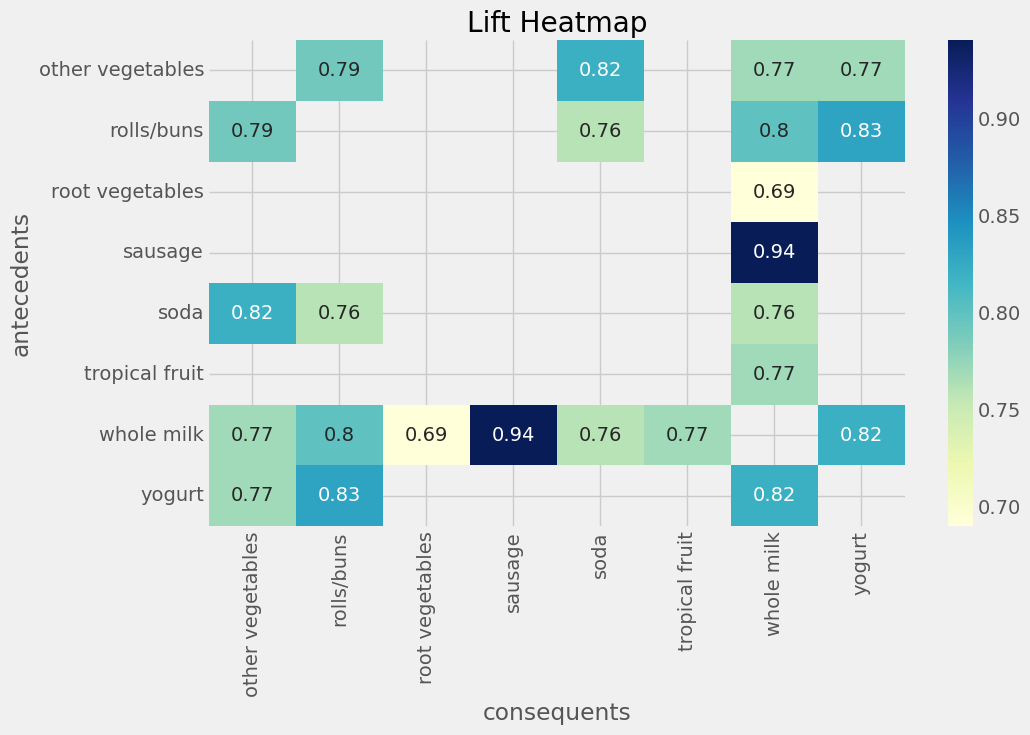

In [ ]:
# Create a pivot table for lift values
pivot = rules.pivot(index='antecedents', columns='consequents', values='lift')

# Generate heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Lift Heatmap")
plt.show()


##### Insights from heatmap

Lift Values Interpretation: Lift is a measure used in association rule mining that tells us how much more likely the consequent is bought with the antecedent than on its own. A lift value greater than 1 indicates that two items are more likely to be bought together than separately, while a lift value less than 1 means the items are unlikely to be bought together.

Diagonal Empty Values: The diagonal of the heatmap is empty, which makes sense because it would be the lift value of a product with itself.

High Lift Values:

The combination of yogurt as antecedent and whole milk as consequent has a lift of 0.83, indicating that they are often bought together.
The combination of root vegetables and sausage has a lift of 0.94, suggesting a strong association between these two items.
Similarly, rolls/buns and other vegetables have a lift of 0.79, implying they are also commonly bought together.
Moderate Lift Values:

Items like rolls/buns with whole milk, and other vegetables with whole milk have lifts close to 0.8, indicating a moderate likelihood of being bought together.
soda and whole milk, yogurt and other vegetables, yogurt and rolls/buns all have lift values that are around 0.76 to 0.83, again suggesting a moderate association.
Low Lift Values:

The combination of root vegetables with whole milk has a lower lift of 0.69, which implies that they might not be as frequently bought together compared to other product combinations on this heatmap.
Color Gradient: The color gradient on the right side of the heatmap ranges from light (low lift) to dark (high lift). This gradient provides a visual indication of the strength of the association between the products. The darker the square, the stronger the association.

Symmetry: The heatmap appears to be symmetric about its diagonal. This is expected since the lift of item A with item B should be the same as the lift of item B with item A.

In summary, the heatmap provides insights into which products are often bought together in the dataset. Some products like root vegetables and sausage, or yogurt and whole milk, have strong associations, while others like root vegetables and whole milk have weaker associations. These insights can be valuable for retailers when considering cross-promotion, product placement, or marketing strategies.

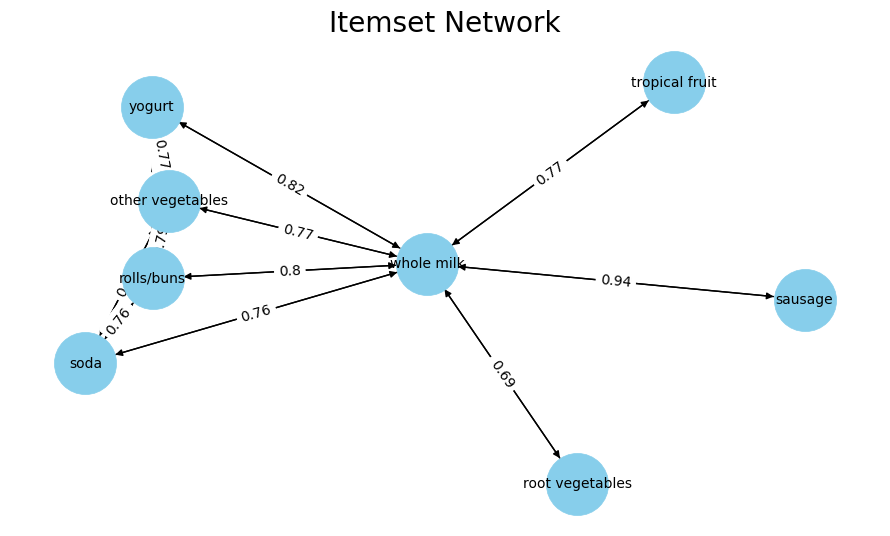

In [ ]:
# Create a new directed graph from edges
G = nx.from_pandas_edgelist(rules, source='antecedents', target='consequents', edge_attr=True, create_using=nx.DiGraph())

# Create a new matplotlib axes object
fig, ax = plt.subplots(figsize=(10, 6))

# Draw the graph on the axes object
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, ax=ax)
labels = nx.get_edge_attributes(G, 'lift')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
ax.set_title("Itemset Network")

# Show the plot
plt.show()

The network graph, visually represents relationships between various itemsets. In this context, the nodes (circles) represent different products (itemsets), and the edges (lines) between nodes indicate an association between the connected products. The value on each edge represents the strength of the association, which in this case seems to be the lift value we discussed previously.

Let's break down the insights from this Itemset Network:

Nodes & Central Items:
The node labeled frozenset({'whole milk'}) seems to be the central item of this network, indicating that it has relationships with several other products.
Nodes like frozenset({'yogurt'}), frozenset({'other vegetables'}), and others surround the central node, suggesting they are some of the primary products associated with whole milk.

Strong Associations:
The connection between root vegetables and sausage is notable, with a lift of 0.94. This is one of the strongest associations in the network.
rolls/buns and other vegetables have a strong connection, with a lift of 0.83.
Similarly, yogurt and whole milk have a strong connection, evidenced by a lift of 0.82.

Moderate Associations:
rolls/buns and soda have a lift of 0.76, indicating a moderate association.
other vegetables and soda have a similar association, with a lift of 0.76.
yogurt and other vegetables are also moderately connected, with a lift of 0.77.

Weak Associations:
The connection between whole milk and root vegetables is weaker, with a lift value of 0.69.
Notably, tropical fruit has only a single connection to yogurt, with a lift of 0.71. This indicates that among the items shown, tropical fruit is most associated with yogurt but the strength of this association is relatively low.
Isolated Nodes: There aren't any completely isolated nodes (nodes without any connections) in this network. This suggests that each product shown has at least one notable association with another product.

Layout & Connectivity: The layout of the nodes suggests whole milk might be a commonly purchased item, given its central position and the number of connections it has. Items directly connected to it can be considered as complementary products or items that customers tend to purchase together with whole milk.

In summary, this Itemset Network provides a visual representation of the relationships between various products. Some products, like whole milk, have several associations, while others, like tropical fruit, have fewer. The strength of each association, indicated by the lift value, helps in understanding which products are often purchased together. This can again be of great value for strategic product placement, bundling offers, and targeted promotions in a retail setting.

In [ ]:
# Getting the most popular association rules? 

# top_patterns? 

# test to see which items to recommend, after seeing only 1 item from the customer (1 antecedent)

# Time-based Analysis: Since your data spans multiple years, you might consider running the Apriori algorithm on a subset of the data based on time periods (e.g., monthly or yearly) to see if shopping patterns have changed over time.

# Customer Segmentation: You could also segment your customers based on certain characteristics or behaviors and run the Apriori algorithm for each segment to find more targeted association rules.

# Item Categorization: If your items can be categorized (e.g., dairy, fruits, beverages), you might consider running the algorithm on these categories instead of individual items for a higher-level view of associations.